In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
import math

In [3]:
Tier1Shops=pd.DataFrame({'Store/Location Name': ['RETAIL SARIT', 'RETAIL YAYA', 'RETAIL HILTON', 'RETAIL VILLAGE MARKET'], 'Tier': ['Tier1', 'Tier1', 'Tier1', 'Tier1']})

In [2]:
selling_price=pd.read_excel("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Retail Label Printing Inc. VAT_04_05.xlsx")

blocked_items = pd.read_excel("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Item Block.xlsx")

stock_and_sales=pd.read_csv("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Stock&Monthwise_2022TD_Stock+Sales.csv")

GP_table=pd.read_csv("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\GPs.csv")

Instock_import = pd.read_excel("C:\\Users\\David.Clinton\\Desktop\\David\\Stock & Monthwise Current Month\\03_2024.xlsx")

read_min_max= pd.read_excel("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\MIN MAX\\min max as at 04_03_2024.xlsx")

In [7]:
stock_and_salesB=stock_and_sales.copy()

OKAY. NOW WE START THE ROTATION PROCESS. PRICES ANALYSIS WILL PROVE USEFUL WHEN IT COMES TO PRODUCTS THAT CAN ROTATE BASED ON HISTORICAL SALES. WE'LL HAVE TO LOOK AT IT FROM A DEPARTMENTAL POV

In [8]:
#stock_and_sales [stock_and_sales ['Item Description'] == "MARIGOLD VEGAN GF ENGEVITA YEAST FLAKES 100G#MG15689"]

In [9]:
stock_and_sales_C=stock_and_sales.copy()

In [10]:
stock_and_sales_C['Item No.']=stock_and_sales_C ['Item No.'].astype(str)

In [11]:
#Omitting Carrefour

In [12]:
stock_and_sales_C=stock_and_sales_C[~stock_and_sales_C.isin({'Store/Location Name': ['CARREFOUR MEGA (EXPRESS)']})['Store/Location Name']]

In [13]:
stock_and_sales_C=stock_and_sales_C[~stock_and_sales_C.isin({'Department': ['Giftware', 'Gftware', 'Packaging Materials', 'Assets & Consumables']})['Department']]

We need to create a move to table, based on sales and GP
If GP is above 0.23 and sell rate is 0.25 and shop can hold the incoming stock for the next two months. Shop transferring the item should be left with two months of sales stock.

Rotate to shops first, then to warehouse if item is shared. How will we know shared items? Anyhting that has sold in both retail and main can be considered as shared. However, if it hasn't sold in main for the last 3 months, we can assume it has switched to retail only and vice versa.

In [14]:
stock_shops=stock_and_sales_C[['Item Description', 'Store/Location Name']].groupby('Item Description')['Store/Location Name'].agg(set)

In [15]:
stock_shop_dict=stock_shops.to_dict()

In [16]:
shared=[]
for i in stock_shop_dict:
    if 'MAIN WAREHOUSE' in stock_shop_dict[i]:
        shared.append(i)

shared has a list of all shared items

In [18]:
Instock_import ['Item No.']= Instock_import ['Item No.'].astype(str)

In [19]:
path_current_month="C:\\Users\\David.Clinton\\Desktop\\David\\Stock & Monthwise Current Month"
file_names_current_month=[]
for i in os.listdir(path_current_month):
    file_names_current_month.append(i.replace('.xlsx', ""))


In [20]:
file_names_current_month

['03_2024']

In [21]:
#DYMATIZE ISO-100 GOURMET VANILLA 2.3KG #D35321A

In [22]:
#Lets calculate current month rate of sale. Will help to check if the sale is picking up. If it is picking up, then we don't
# move the item. If it is constant or dropping, then transfer.

index_start=0

index_trace=[]
holding_list=[]
for i in file_names_current_month:
    month = re.search('[0-9]+', i).group()
    year=re.search('[^_]*$', i).group()
    
    file_name="C:\\Users\\David.Clinton\\Desktop\\David\\Stock & Monthwise Current Month\\{x}_{y}.xlsx"
    temp_table=pd.read_excel(file_name.format(x=month, y=year))
    temp_table['Month']= int(month)
    temp_table['Year']=int(year)
    index_trace.append(len(temp_table))
    temp_table.set_axis(range(index_start, sum(index_trace)), inplace=True)
    temp_table['monthlystock'+month]= temp_table['Total Quantity Sold']+temp_table['Closing Stock']
    temp_table['month'+month+year+'sales']=temp_table['Total Sales Amount']
    #temp_table['month'+month+year+'GP']=temp_table['Gross Profit %']
    temp_table ['month'+month+year+'COGS']=temp_table['COGS']
    holding_list.append(temp_table)
    #print (index_start, index_trace )
    index_start=sum(index_trace)
    
table_current_month=pd.concat(holding_list)

In [23]:
QtySold=table_current_month[[ i for i in table_current_month.columns if 'Qty' in i ]].sum(axis=1)
table_current_month['Current_Month_QtySold']=QtySold
table_current_month ['Sell_Rate_Current_Month']=table_current_month.Current_Month_QtySold/table_current_month.monthlystock03
#The line above is changeable. monthlystock should change to current month
current_stock=Instock_import[['Item Description', 'Item No.', 'Store/Location Name', 'InStock']]

In [24]:
sell_rate_table_current_month=table_current_month[['Item Description', 'Item No.', 'Store/Location Name', 'Sell_Rate_Current_Month']].copy()

In [25]:
array=stock_and_sales_C[[i for i in stock_and_sales_C.columns if 'Sold' in i]].values

In [26]:
medianlast6months=np.median(array[:,-6:], axis=1)
medianlast3months=np.median(array[:,-3:], axis=1)
medianbeforelast6months = np.median (array[:,-6::-1])

In [27]:
stock_and_sales_D=stock_and_sales_C.copy()

In [28]:
stock_and_sales_D['units_sold_median_last6']=medianlast6months
stock_and_sales_D['units_sold_median_last3']=medianlast3months
stock_and_sales_D['units_sold_before_the_last6']=medianbeforelast6months

NOW THAT WE HAVE THE MIN MAX...WE CAN USE THE MEAN FROM MIN MAX AS HARMNONIZED MEAN

In [30]:
read_min_max['Mean'] = read_min_max.Mean.apply(lambda x: 1 if x < 1 else x)

In [31]:
read_min_max['Item No.'] = read_min_max['Item No.'].astype(str)

In [32]:
# read_min_max [read_min_max ['Item No.']==40225010242]

In [33]:
read_min_max.drop_duplicates(inplace=True) 

In [34]:
# nw=new_item_codes [['New Item No.', 'Existing Old Item Code']]
# nw=nw.copy()

In [35]:
# nw ['New Item No.'] = nw ['New Item No.'].astype(str) 
# nw ['Existing Old Item Code']  = nw ['Existing Old Item Code'].astype(str) 

In [36]:
def harmonizedmean(x):
    if x.units_sold_median_last6 <= x.units_sold_median_last3:
        return x.units_sold_median_last3
    
    elif x.units_sold_median_last6 <=0 and x.units_sold_median_last3 <=0:
        return medianbeforelast6months
        # in case we don't have last 6 months data, go back to before the last 6 months
    
    else:
        return x.units_sold_median_last6
    
harmonized_mean=stock_and_sales_D.apply(harmonizedmean, axis=1)

In [37]:
stock_and_sales_D['harmonized_mean'] = harmonized_mean

In [38]:
# stock_and_sales_D[stock_and_sales_D ['Item No.']=='30128680001'] [['Item No.', 'Store/Location Name', 'harmonized_mean']]

In [39]:
read_min_max.rename(columns= {'Branches': 'Store/Location Name'}, inplace=True)

In [40]:
stock_and_sales_D=pd.merge(left=stock_and_sales_D, right = read_min_max[['Item No.', 'Store/Location Name', 'Mean']], on = ['Item No.','Store/Location Name'], how='left')

In [41]:
stock_and_sales_D ['Item No.'] = stock_and_sales_D ['Item No.'].astype(str)

In [42]:
# stock_and_sales_D [stock_and_sales_D ['Item No.']==18200910012].to_csv('sfdf.csv')

In [43]:
stock_and_sales_D.rename(columns={'harmonized_mean': 'old_harmonized_mean', 'Mean': 'harmonized_mean'}, inplace=True)

In [44]:
stock_and_sales_D['MaxStock']=stock_and_sales_D.harmonized_mean * 1.5
stock_and_sales_D['MinStock']=stock_and_sales_D.harmonized_mean * 0.9

In [45]:
current_stock ['Item No.'] = current_stock ['Item No.'].astype(str)

C:\Users\Geoffrey.Oute\AppData\Local\Temp\ipykernel_10432\2614597672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_stock ['Item No.'] = current_stock ['Item No.'].astype(str)


In [46]:
stock_and_sales_E=pd.merge(left=stock_and_sales_D, right=current_stock, on=['Item No.','Store/Location Name'], how='left')

In [47]:
# nw['Item No.'].info()

In [48]:
stock_and_sales_E=pd.merge(left=stock_and_sales_E, right=Tier1Shops, on=['Store/Location Name'], how='left')

In [49]:
stock_and_sales_E.InStock = stock_and_sales_E.InStock.fillna(0)

In [50]:
median_sell_rate=np.median(stock_and_sales_E[[i for i in stock_and_sales_E.columns if 'Sell' in i][-3:]],axis=1)

In [51]:
stock_and_sales_E['median_sell_rate']=median_sell_rate

In [52]:
sell_rate_table_current_month['Item No.'] = sell_rate_table_current_month['Item No.'].astype(str)
stock_and_sales_E['Item No.'] = stock_and_sales_E['Item No.'].astype(str)

In [53]:
sell_rate_table_current_month ['Item No.'] = sell_rate_table_current_month ['Item No.'].astype(str)

In [54]:
stock_and_sales_E=pd.merge(left=stock_and_sales_E, right=sell_rate_table_current_month, on=['Item No.', 'Store/Location Name'], how='left')

In [55]:
median_sell_rate_arrays=stock_and_sales_E.median_sell_rate.values
median_sell_rate_arrays[median_sell_rate_arrays==0]=0.01
#changing all median sell rates that are at 0 to 0.01 so that we can be able to calculate the months it will take to clear
#the stock

In [56]:
five_elements=stock_and_sales_E[stock_and_sales_E.isin({'Store/Location Name': ['RETAIL THE FIVE ELEMENTS', 'RETAIL FIVE ELEMENTS NYALI']})['Store/Location Name']]

#lets remove giftware shops from suggestion list

stock_and_sales_E.drop(five_elements.index, inplace=True)

In [57]:
def excess_stock_func(x):
    try:
        if x.Tier=='Tier1':
#             one_month_cover=x.InStock/(x.median_sell_rate*x.InStock)
            three_months_cover=x.harmonized_mean*3
            excess_stock=x.InStock-three_months_cover
        else:
#             one_month_cover=x.InStock/(x.median_sell_rate*x.InStock)
            two_months_cover=x.harmonized_mean*2
            excess_stock=x.InStock-two_months_cover
            
    except ZeroDivisionError:
        excess_stock = None
        
        
    return excess_stock    
        
        
        
        

In [58]:
def months_cover(x):
    try:
        if x.Tier=='Tier1':
#             one_month_cover=x.InStock/(x.median_sell_rate*x.InStock)
#lets use median qty sold only [harmonized]
            months_cover_2_3=x.harmonized_mean*3
           
        else:
#             one_month_cover=x.InStock/(x.median_sell_rate*x.InStock)
            months_cover_2_3=x.harmonized_mean*2
            
            
    except ZeroDivisionError:
        months_cover_2_3 = None
        
    return months_cover_2_3

In [59]:
excess_stock2=stock_and_sales_E.apply(excess_stock_func, axis=1)
months_cover=stock_and_sales_E.apply(months_cover, axis=1)

In [60]:
stock_and_sales_E['Months_Cover_2_3']=months_cover
stock_and_sales_E['Excess_stock']=excess_stock2

In [61]:
stock_and_sales_E[stock_and_sales_E ['Store/Location Name']=='RETAIL WAREHOUSE'].Excess_stock.unique()

array([nan])

CREATING THE MOVE TO TABLE
There are products in main warehouse that sell with a rate of below 0.25. e.g 11/100 a month. So for main warehouse, we pull it from the list and join it later so that we don't limit options that can move into main warehouse

In [62]:
stock_and_sales_F=stock_and_sales_E.copy()

In [63]:
main_warehouse_move_to=stock_and_sales_F[stock_and_sales_F['Store/Location Name'] == 'MAIN WAREHOUSE']

In [64]:
stock_and_sales_F.drop(main_warehouse_move_to.index, inplace=True)

In [65]:
# stock_and_sales_F[stock_and_sales_F['Item No.']=='162000018'][stock_and_sales_F[stock_and_sales_F['Item No.']=='162000018']['Store/Location Name']=='RETAIL SARIT']

In [66]:
move_to_table=stock_and_sales_F.copy()

In [67]:
#On a second thought, lets not concatenate main. This will be taken care of by rebalancing  

In [68]:
move_to_table=pd.concat([move_to_table, 
#                          main_warehouse_move_to
                        ], 
                        ignore_index=True)

In [69]:
Golden_Life=move_to_table[move_to_table ['Store/Location Name'] ==  'RETAIL NAKURU GOLDENLIFE']

In [70]:
Elodret_Highlands = move_to_table[move_to_table ['Store/Location Name'] ==  'RETAIL ELDORET HIGHLANDS']

In [71]:
move_to_table.drop(Golden_Life.index, inplace=True)

In [72]:
move_to_table.drop(Elodret_Highlands.index, inplace=True)

In [73]:
move_to_table.loc[:, 'Capacity']=move_to_table.loc[:, 'MaxStock']-move_to_table.loc[:, 'InStock']

In [74]:
def check_improvement(x):
    if x.median_sell_rate <= 0.10 and x.Sell_Rate_Current_Month>=0.17:
        return 'Increased_Velocity'
    else:
        return 'Constant_Velocity'
    

In [75]:
# we have to omit receiving and production warehouse first. We'll rotate/send to of these categories later. First we deal with 
#what is in the shops. Order is shops, retail warehouse, main, then receiving and production

In [76]:
stock_and_sales_E.InStock.sum()

637367.0299999999

In [77]:
pull_from_table=stock_and_sales_E[stock_and_sales_E['median_sell_rate']<0.25].copy()

#remember that table F does not have main warehouse. We dropped. But we can use table E
pull_from_table.sort_values(by='Excess_stock', ascending=False, inplace=True)
pull_from_table=pull_from_table[~pull_from_table.isin({'Store/Location Name': ['MAIN WAREHOUSE', 'PACKAGING MATERIALS WAREHOUSE','QUALITY CONTROL WAREHOUSE',
                                                              'RECEIVING WAREHOUSE', 'DAMAGES & EXPIRY WAREHOUSE','IVEND INTRANSIT WAREHOUSE',
                                                              'PRODUCTION WAREHOUSE', 'MAJID RETURNS WAREHOUSE', 'RETAIL OVERSTOCK WAREHOUSE',
                                                              'FIXED ASSETS & CONSUMMABLES','VARIANCE MAIN WAREHOUSE', 'RETAIL WAREHOUSE',
                                                             ]})['Store/Location Name']]

# pull_from_table= pull_from_table[pull_from_table.InStock>0]
# velocity_pl=pull_from_table.apply(check_improvement, axis=1)
# pull_from_table['Velocity']=velocity_pl
# pull_from_table=pull_from_table[pull_from_table ['Velocity'] == 'Constant_Velocity']
# pull_from_table['Unique_Index']=pull_from_table['Item Description_x']+pull_from_table['Store/Location Name']

In [78]:
pull_from_table_retail_warehouse=stock_and_sales_E[stock_and_sales_E['median_sell_rate']<0.25].copy()
#cant give retail warehouse median sell rate condition because it is not a selling warehouse
pull_from_table_retail_warehouse.sort_values(by='Excess_stock', ascending=False, inplace=True)
pull_from_table_retail_warehouse = pull_from_table_retail_warehouse[pull_from_table_retail_warehouse.isin({'Store/Location Name': ['RETAIL WAREHOUSE']})['Store/Location Name']]
pull_from_table_retail_warehouse= pull_from_table_retail_warehouse[pull_from_table_retail_warehouse.InStock>0]
velocity_pl_retail_warehouse=pull_from_table_retail_warehouse.apply(check_improvement, axis=1)
pull_from_table_retail_warehouse['Velocity']=velocity_pl_retail_warehouse
pull_from_table_retail_warehouse['Unique_Index'] = pull_from_table_retail_warehouse ['Item Description_x']+pull_from_table_retail_warehouse['Store/Location Name']

In [79]:
# pull_from_table_receiving_warehouse.Excess_stock.unique()

In [80]:
# #========================================================================================================================================================================================
pull_from_table_main_warehouse=stock_and_sales_E[stock_and_sales_E['median_sell_rate']<0.25].copy()
pull_from_table_main_warehouse.sort_values(by='Excess_stock', ascending=False, inplace=True)
pull_from_table_main_warehouse = pull_from_table_main_warehouse[pull_from_table_main_warehouse.isin({'Store/Location Name': ['MAIN WAREHOUSE']})['Store/Location Name']]
pull_from_table_main_warehouse= pull_from_table_main_warehouse[pull_from_table_main_warehouse.InStock>0]
velocity_pl_main_warehouse=pull_from_table_main_warehouse.apply(check_improvement, axis=1)
pull_from_table_main_warehouse['Velocity']=velocity_pl_main_warehouse
pull_from_table_main_warehouse ['Unique_Index'] = pull_from_table_main_warehouse ['Item Description_x']+ pull_from_table_main_warehouse ['Store/Location Name']
# #========================================================================================================================================================================================
pull_from_table_receiving_warehouse=stock_and_sales_E[stock_and_sales_E['median_sell_rate']<0.25].copy()
pull_from_table_receiving_warehouse.sort_values(by='Excess_stock', ascending=False, inplace=True)
pull_from_table_receiving_warehouse = pull_from_table_receiving_warehouse[pull_from_table_receiving_warehouse.isin({'Store/Location Name': ['RECEIVING WAREHOUSE']})['Store/Location Name']]
pull_from_table_receiving_warehouse= pull_from_table_receiving_warehouse[pull_from_table_receiving_warehouse.InStock>0]
velocity_pl_receiving_warehouse=pull_from_table_receiving_warehouse.apply(check_improvement, axis=1)
pull_from_table_receiving_warehouse['Velocity']=velocity_pl_receiving_warehouse
pull_from_table_receiving_warehouse ['Unique_Index'] = pull_from_table_receiving_warehouse ['Item Description_x'] + pull_from_table_receiving_warehouse ['Store/Location Name']
# #========================================================================================================================================================================================

pull_from_table_production_warehouse=stock_and_sales_E[stock_and_sales_E['median_sell_rate']<0.25].copy()
pull_from_table_production_warehouse.sort_values(by='Excess_stock', ascending=False, inplace=True)
pull_from_table_production_warehouse = pull_from_table_production_warehouse[pull_from_table_production_warehouse.isin({'Store/Location Name': ['PRODUCTION WAREHOUSE']})['Store/Location Name']]
pull_from_table_production_warehouse= pull_from_table_production_warehouse[pull_from_table_production_warehouse.InStock>0]
velocity_pl_production_warehouse=pull_from_table_production_warehouse.apply(check_improvement, axis=1)
pull_from_table_production_warehouse['Velocity']=velocity_pl_production_warehouse
pull_from_table_production_warehouse ['Unique_Index'] = pull_from_table_production_warehouse ['Item Description_x']+ pull_from_table_production_warehouse ['Store/Location Name']                                                  
                                        

In [81]:
#Ignore pull_from_table cos this will pull from other shops
#Lets not pull production whse
# We'll remove the two above from concat

In [82]:
combined_table=pd.concat([pull_from_table_retail_warehouse, pull_from_table_main_warehouse, pull_from_table_receiving_warehouse])

In [83]:
def Capactiy2(x):
    if x.Capacity > 0 and x.Capacity<1:
        return 1
    elif x.Capacity >= 1:
        return round(x.Capacity)
    else:
        return x.Capacity

In [85]:
move_to_table.insert(6, 'Vendor Name', 'N/A')

In [86]:
move_to_table_B=move_to_table[[ 'Item No.','Item Description_x','Brand', 'Store/Location Name', 'Location Type',
                                                     'Vendor Name', 'median_sell_rate','MaxStock', 'MinStock','Capacity','InStock'
              
                                                     ]].copy()



move_to_table_B['CapacityRounded']=move_to_table_B.apply(Capactiy2, axis=1)

In [87]:
giftware=move_to_table_B[move_to_table_B.isin({'Store/Location Name': ['RETAIL THE FIVE ELEMENTS', 'RETAIL FIVE ELEMENTS NYALI']})['Store/Location Name']]

#lets remove giftware shops from suggestion list

move_to_table_B.drop(giftware.index, inplace=True)

In [88]:
combined_table2=pd.concat([Instock_import[Instock_import ['Store/Location Name'] =='RETAIL WAREHOUSE'].copy(),
                           Instock_import[Instock_import ['Store/Location Name'] =='MAIN WAREHOUSE'].copy(),
                           
                          ])

In [89]:
combined_table2 ['Unique_Index'] = combined_table2 ['Item Description'] + combined_table2 ['Store/Location Name']

In [90]:
combined_table2.rename(columns={'InStock': 'Excess_stock', 'Item Description': 'Item Description_x'}, inplace=True)

In [91]:
# move_to_table[move_to_table ['Item No.']=='155000324'].to_csv('sdsf.csv')

In [92]:
read_min_max ['Item No.'] = read_min_max ['Item No.'].astype(str)

combined_table2 ['Item No.'] = combined_table2 ['Item No.'].astype(str)

In [93]:
combined_table3=pd.merge(left=combined_table2, right = read_min_max [['Item No.', 'Store/Location Name', 'Mean']], on =['Item No.', 'Store/Location Name'], how='left')

if Item has recently picked sales, above or equal to 0.2, leave the stock as is. Else remove excess.

In [94]:
combined_table3.columns

Index(['#', 'Mode of Business', 'Core Type', 'Location Type', 'Item No.',
       'Bar Code', 'Item Description_x', 'Department', 'Brand', 'Vendor Code',
       'Vendor Name', 'Store/Location Code', 'Store/Location Name',
       'Excess_stock', 'Opening Stock', 'Purchased Quantity',
       'Purchase Return Quantity', 'Open PO Qty', 'Order Quantity',
       'Jan Qty Sold', 'Feb Qty Sold', 'Mar Qty Sold', 'Apr Qty Sold',
       'May Qty Sold', 'Jun Qty Sold', 'Jul Qty Sold', 'Aug Qty Sold',
       'Sep Qty Sold', 'Oct Qty Sold', 'Nov Qty Sold', 'Dec Qty Sold',
       'Total Quantity Sold', 'Closing Stock', 'Retail Price Ex. VAT',
       'Retail Price Inc VAT', 'COGS', 'Total Sales Amount', 'Gross Profit',
       'Gross Profit %', 'Unique_Index', 'Mean'],
      dtype='object')

In [99]:
combined_table4 = combined_table3.copy()

In [100]:
def Brand_Block(x):
    if (x['Brand'] == 'ECOVER' or x ['Brand'] == 'METHOD') and (x ['Store/Location Name'] in ['RETAIL HILTON', 'RETAIL T-MALL', 'RETAIL CAPITAL CENTRE', 'RETAIL EASTLEIGH BRANCH', 'RETAIL MAIYAN MALL']):
        return 'Block'
    else:
        return 'Proceed'

In [101]:
def Brand_Block2(x):
    if (x['Brand'] == "DR BRONNER'S" or x ['Brand'] == 'HEMANI') and (x ['Store/Location Name'] in ["CARREFOUR MEGA (EXPRESS)"]):
        return 'Block'
    else:
        return 'Proceed'

In [102]:
move_to_table_B ['Block_Status'] = move_to_table_B.apply(Brand_Block2, axis=1)

In [103]:
move_to_table_B ['Block_Status'] = move_to_table_B.apply(Brand_Block, axis=1)

In [104]:
department_dictionary=dict(read_min_max[['Item No.', 'Department']].values)

In [105]:
move_to_table_B ['Department'] = move_to_table_B['Item No.'].apply(lambda x: department_dictionary[x] if x in department_dictionary else 'No Dep')

In [106]:
def Department_Block(x):
    if (x['Department'] == 'Baby foods') and (x ['Store/Location Name'] in ['RETAIL HILTON']):
        return 'Block'
    else:
        return 'Proceed'
    

In [107]:
move_to_table_B ['Department_Block'] = move_to_table_B.apply(Department_Block, axis=1)

In [108]:
indices_omit=list(set(list(move_to_table_B [move_to_table_B ['Block_Status'] == 'Block'].index)+list(move_to_table_B [move_to_table_B ['Department_Block'] == 'Block'].index)))

In [109]:
move_to_table_B.drop(indices_omit, inplace=True)

In [110]:
move_to_table_B.set_axis(range(0, len(move_to_table_B)), inplace=True)

In [111]:
move_to_table_B.drop(['Block_Status', 'Department', 'Department_Block'], axis=1, inplace=True)

In [112]:
move_to_table_B.head(4)

,Item No.,Item Description_x,Brand,Store/Location Name,Location Type,Vendor Name,median_sell_rate,MaxStock,MinStock,Capacity,InStock,CapacityRounded
0,159000001,A.VOGEL AGNUS CASTUS 50ML,A.VOGEL,IVEND INTRANSIT WAREHOUSE,Warehouse,N/A,0.01,NaN,NaN,NaN,0.0,NaN
1,159000001,A.VOGEL AGNUS CASTUS 50ML,A.VOGEL,RETAIL ABC,Retail,N/A,0.01,1.5,0.9,-0.5,2.0,-0.5
2,159000001,A.VOGEL AGNUS CASTUS 50ML,A.VOGEL,RETAIL CAPITAL CENTRE,Retail,N/A,0.01,1.5,0.9,-0.5,2.0,-0.5
3,159000001,A.VOGEL AGNUS CASTUS 50ML,A.VOGEL,RETAIL EASTLEIGH BRANCH,Retail,N/A,0.25,1.5,0.9,-1.5,3.0,-1.5


In [113]:
blocked_items ['Status'] = 'Block'

In [114]:
blocked_items['Item No.'] = blocked_items['Item No.'].astype(str)

In [115]:
move_to_table_B ['Item_Shop'] = move_to_table_B ['Item No.']+ move_to_table_B ['Store/Location Name']

In [116]:
blocked_items ['Item_Shop'] =blocked_items ['Item No.']+ blocked_items ['Retail Shop']

In [117]:
blocked_items.rename(columns={'Item No.': 'Item Code'}, inplace=True)

In [118]:
move_to_table_BBB = pd.merge(left = move_to_table_B, right = blocked_items, on=['Item_Shop'], how='left')

In [119]:
move_to_table_B = move_to_table_BBB [~move_to_table_BBB.isin({'Status': ['Block']})['Status']].copy()

In [120]:
# move_to_table_B.drop(['Item_Shop', 'Item '])

In [121]:
move_to_table_B.drop(move_to_table_B.iloc[:, 12:].columns, axis=1, inplace=True)

In [122]:
rotation =[]
rotation2 =[]

In [123]:
combined_table4.Excess_stock

0       42.0
1        3.0
2       35.0
3        1.0
4       85.0
        ... 
2906     6.0
2907     0.0
2908    53.0
2909    32.0
2910     0.0
Name: Excess_stock, Length: 2911, dtype: float64

In [124]:
def FilterTable():
    for i in combined_table4.Unique_Index.values:
        temp_table=combined_table4[combined_table4 ['Unique_Index'] == i]
        brand=temp_table.Brand.values[0]
        department = temp_table.Department.values[0]
        
        units_aged=temp_table.Excess_stock.values[0] #change this part..units_aged should be excess_stock. code is from ageing stock rotation
        item_code = temp_table['Item No.'].values[0]
        item_desc=temp_table['Item Description_x'].values[0]
        from_shop=temp_table['Store/Location Name'].values[0]
        
        temp_table_move_to=move_to_table_B[move_to_table_B['Item No.']==item_code].sort_values(by='Capacity', 
                                                                                         ascending=False).sort_values(by='InStock',
                                                                                                                      ascending=True)
        #let go of item description. It changes. Use Item No.
        try:
            if temp_table_move_to.iloc[:1]['Store/Location Name'].values[0]=='MAIN WAREHOUSE':
                delete=temp_table_move_to[:1]
                temp_table_move_to.drop(delete.index, inplace=True)
                temp_table_move_to=pd.concat([temp_table_move_to, delete])
        except:
            IndexError
 
        
        for i in temp_table_move_to.itertuples(name=None):
            if i[12]>0 and units_aged>=i[12]:
                can_take=i[12]
                to_store=i[4]
                in_stock_to = i[11]
                max_stock_to=i[8]
                
                rotation.append([item_code,item_desc,from_shop,to_store,in_stock_to,max_stock_to,can_take,brand, department])
                units_aged=units_aged - can_take
            
                move_to_table_B.loc[i[0]:i[0], 'CapacityRounded']=move_to_table_B.loc[i[0]:i[0], 'CapacityRounded'] - can_take
            
                if units_aged<=0:
                    break;
            elif i[12]>0 and units_aged<i[12]:
                can_take=units_aged
                to_store=i[4]
                in_stock_to = i[11]
                max_stock_to=i[8]
                
                rotation.append([item_code,item_desc,from_shop,to_store,in_stock_to,max_stock_to,can_take, brand, department])
                
                units_aged=units_aged - can_take
                
                move_to_table_B.loc[i[0]:i[0], 'CapacityRounded']=move_to_table_B.loc[i[0]:i[0], 'CapacityRounded'] - can_take
                if units_aged<=0:
                    break;
                    
        if units_aged>0:
            other_options = 'other_options'
            to_storeB=from_shop
            rotation2.append([item_code,item_desc ,from_shop, to_storeB,units_aged,'N/A',other_options, brand, department])
                
    table1= pd.DataFrame(rotation+rotation2, columns=['Item Code','ItemDescription' ,'MoveFrom', 'MoveTo', 'Instock', 'MaxStock', 'Movable_Units', 'Brand', 'Department'])
    return table1
    

In [125]:
tableP=FilterTable()

In [126]:
tableP.head()

,Item Code,ItemDescription,MoveFrom,MoveTo,Instock,MaxStock,Movable_Units,Brand,Department
0,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL NANYUKI,0.0,1.5,2.0,SUNWARRIOR,Sports Nutrition
1,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL EASTLEIGH BRANCH,0.0,1.5,2.0,SUNWARRIOR,Sports Nutrition
2,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL GARDEN CITY,0.0,1.5,2.0,SUNWARRIOR,Sports Nutrition
3,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL KISUMU MEGA,0.0,1.5,2.0,SUNWARRIOR,Sports Nutrition
4,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL LIKONI,0.0,1.5,2.0,SUNWARRIOR,Sports Nutrition


In [127]:
tableQ=tableP.copy()
other_options=tableQ[tableQ.Movable_Units=='other_options']
tableQ.drop(other_options.index, inplace=True)
tableQ=tableQ[tableQ.Movable_Units>0]

In [128]:
less_than_30 = tableQ[tableQ ['Instock'] < 200]

In [129]:
less_than_30=less_than_30.sort_values(by='Instock')

In [130]:
# move_to_table_B [move_to_table_B ['Item No.']=='14200720001']

In [131]:
# less_than_30 [less_than_30 ['Item Code']=='14200720001']

In [132]:
ivend2 = pd.read_excel("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Positive Inventory\\Positive Inventory (Retail) 25.03.2024.xlsx")
ivend_comb=pd.concat([ivend2['Item No.'], ivend2[[i for i in ivend2.columns if 'IVEND' in i]]], axis=1)
cols_extracted = ['RETAIL' + " " + i.replace('IVEND INTRANSIT', "").strip() for i in ivend_comb.columns if 'IVEND' in i]
ivend_comb.columns = ['Item No.'] + cols_extracted
ivend_temp1=ivend_comb [ivend_comb.iloc[:, 1:].sum(axis=1)>0].copy()

In [133]:
holding_list=[]

In [134]:
for i in ivend_temp1.columns[1:]:
    
    inner_temp = ivend_temp1[['Item No.',i]][ivend_temp1[['Item No.',i]][i]>0]

    inner_temp ['To Warehouse'] = inner_temp.columns[1]

    inner_temp.groupby(['Item No.', 'To Warehouse']).sum().reset_index(inplace=True)

    holding_list.append(inner_temp.values)

In [135]:
ivend_final = pd.concat([pd.DataFrame(i) for i in holding_list], ignore_index=True)

ivend_final.columns = ['Product Code', 'UOM Quantity Open', 'To Warehouse']

In [136]:
ivend_final['Product Code'] = ivend_final['Product Code'].astype(int)

In [137]:
ivend_final.columns = ['Item Code', 'Ivend_Open', 'MoveTo']

In [138]:
ivend_current = ivend_final[['Item Code', 'MoveTo', 'Ivend_Open']].copy()

In [139]:
ivend_current['Item Code'] = ivend_current['Item Code'].astype(str)

In [141]:
merged=pd.merge(left=less_than_30, right=ivend_current, on = ['Item Code', 'MoveTo'], how='left')

merged.Ivend_Open.fillna(0, inplace=True)

In [142]:
def subtract_ivend(x):
    if x.Ivend_Open == 0:
        return x.Movable_Units
    
    elif (x.Ivend_Open + x.Instock) > x.MaxStock:
    
        return 'Max Stock Exceeded'
    
    elif (x.Ivend_Open + x.Instock) < x.MaxStock:
        
        return x.MaxStock - (x.Ivend_Open + x.Instock)
        
    else:
        return x.Movable_Units

In [143]:
merged=less_than_30.copy()

In [144]:
merged.rename(columns={'Movable_Units': 'Units'}, inplace=True)

In [145]:
# merged ['Units'] = iven_subtracted

In [146]:
# merged[merged ['Item Code']==14304380005]

In [147]:
finalXXX=merged[['Item Code', 'ItemDescription', 'MoveFrom', 'MoveTo', 'Units', 'Instock',
       'MaxStock', 'Brand', 'Department']].copy()

In [148]:
finalXXX.rename(columns= {'MoveFrom': 'TransferFrom', 'MoveTo': 'TransferTo'}, inplace=True)

In [149]:
finalXXX.head(2)

,Item Code,ItemDescription,TransferFrom,TransferTo,Units,Instock,MaxStock,Brand,Department
0,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL NANYUKI,2.0,0.0,1.5,SUNWARRIOR,Sports Nutrition
7139,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL WESTLANDS SQUARE,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well


In [150]:
# def units_adj(x):
#     if x.Units < 4:
#         return 4
#     else:
#         return math.ceil(x.Units)

In [151]:
#  dont_supply[dont_supply ['Item Code']==14304380001]

In [152]:
dont_supply=finalXXX[finalXXX.Units == 'Max Stock Exceeded'] 

In [153]:
finalXXX.drop(dont_supply.index, inplace=True)

In [154]:
# finalXXX['Units_'] = finalXXX.apply(units_adj, axis=1)

In [155]:
finalXXX.rename(columns={'Units': 'Units_'}, inplace=True)

In [156]:
finalXXX = finalXXX [['Item Code', 'ItemDescription', 'TransferFrom', 'TransferTo', 'Units_',
       'Instock', 'MaxStock', 'Brand', 'Department']]

In [157]:
finalXXX = finalXXX [['Item Code', 'ItemDescription', 'TransferFrom', 'TransferTo', 'Units_',
       'Instock', 'MaxStock', 'Brand', 'Department']]

In [158]:
finalXXX ["Manager's Feedback"] = " "

In [159]:
finalXXX = finalXXX[finalXXX ['Units_']>0]

#### Excluding recent shipments!!!

Activate To Code When There is New Shipment


In [160]:
# bulk.to_csv('bulk.csv')

In [161]:
# non_bulk.to_csv('non_bulk_10_07.csv')

Mute the line below if there is shipment. If there are no shipments, activate the line.

In [162]:
finalAAA=finalXXX[~finalXXX.isin({'Department': ['Frozen Foods']}) ['Department']].copy()

In [163]:
finalAAA.rename(columns={'Units': 'Units_'}, inplace=True)

THIS PART OF THE CODE SHOULD ALWAYS BE THERE!!!!

In [164]:
def reduction_large_containers(x):
    if (x.Brand == 'MUSCLETECH' or x.Brand == 'OPTIMUM NUTRITION' or x.Brand == 'RULE 1') and x.Instock>=2:
        return 0

    elif (x.Brand == 'MUSCLETECH' or x.Brand == 'OPTIMUM NUTRITION' or x.Brand == 'RULE 1') and ('LB' in x.ItemDescription or 'KG' in x.ItemDescription) and x.Units_>5 and (x.TransferTo == 'RETAIL HILTON' or x.TransferTo == 'RETAIL SARIT' or x.TransferTo == 'RETAIL YAYA' or x.TransferTo == 'RETAIL WESTGATE' ):
        return 2
    
    elif (x.Brand == 'MUSCLETECH' or x.Brand == 'OPTIMUM NUTRITION' or x.Brand == 'RULE 1') and ('LB' in x.ItemDescription or 'KG' in x.ItemDescription) and x.Units_>=3:
        return 1
    
    elif (x.Brand == 'MUSCLETECH' or x.Brand == 'OPTIMUM NUTRITION' or x.Brand == 'RULE 1') and x.Units_>=3:
        return 2
    else:
        return x.Units_

In [165]:
units_AAA=finalAAA.apply(reduction_large_containers, axis=1)

In [166]:
finalAAA ['Units_']=units_AAA

In [167]:
finalAAA.drop_duplicates(inplace=True)

<AxesSubplot:xlabel='TransferTo'>

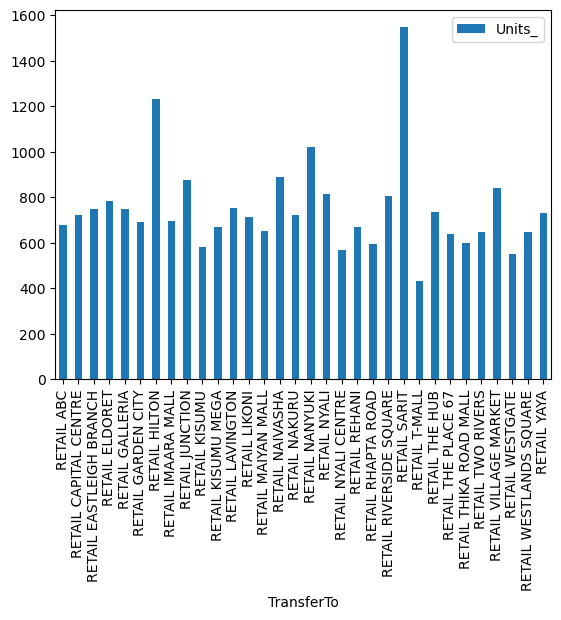

In [168]:
finalAAA.groupby('TransferTo').agg({'Units_': np.sum}).plot(kind='bar')

In [169]:
finalAAA.head(6)

,Item Code,ItemDescription,TransferFrom,TransferTo,Units_,Instock,MaxStock,Brand,Department,Manager's Feedback
0,137000652,SUNWARRIOR ORG ACTIVE PROT VANILLA 1KG#133031011,RETAIL WAREHOUSE,RETAIL NANYUKI,2.0,0.0,1.5,SUNWARRIOR,Sports Nutrition,
7139,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL WESTLANDS SQUARE,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well,
7138,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL WESTGATE,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well,
7137,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL TWO RIVERS,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well,
7136,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL THIKA ROAD MALL,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well,
7135,163000069,LIVE LIFE W ORG STONEGROUND W/MEAL SPELT FLOUR...,RETAIL WAREHOUSE,RETAIL RHAPTA ROAD,2.0,0.0,1.5,LIVE LIFE WELL FLOUR,Live Life Well,


In [170]:
finalCCC=finalAAA[finalAAA.isin({'Department': ['Bulk Foods', 'Live Life Well', 'Naturalli', 'Herbs & Spices']})['Department']].copy()

In [171]:
finalCCC = finalCCC[~finalCCC.isin({'Brand': ["THOMPSON", 'LURON MASSAGE OILS', 'JANI', 'PIKSTERS','ESSENZA', 'HYPODEA','BUKE', 'CINNABAR', 'NIMBLE', 'CLEO NATURE','HELIOCARE 360*', 'BIOFREEZE', 'DIETERS', "O'BAO", 'YVES ROCHER', 'FUSHI', 'ORGANIC SURGE', 'BOOCH', 'GROUNDED','CHIA ORGANIC', 'HGC', 'KAREMBOU SPA', 'KEOLA', 'COTONEVE', 'FAMACOTONE', 'KOKO COSMETICS', 'COTTONS', 'SEVEN SEAS','BIO BALANCE', 'SHEA MOISTURE', 'LULU', 'BREATH OF AFRICA', 'MARINI NATURALS', 'MUSK CARE', 'FLINTSHINE', 'NANO','NATURES WAY', 'UNWIND', 'OPES', 'BOOKS/CARDS', 'WHEY2GO', 'K2U', 'RCI', 'ENSURE', 'BIW', 'IGNITE', 'ANTHEM','BIO-OIL', 'USN', 'PENTA SURE', 'DUNGA SPIRULINA', 'TIWANI', 'UNCOVER', 'VAAJI', 'DIATOMACEOUS', 'SOYBIO', 'KAYA NUTS','ROYAL UMRELLA', 'BAKULI FOODS', 'CHOCODATE', 'BARAKA ISRAEL', 'BIO FOODS', 'BLACK JUICE', 'BERNARD', 'SWEETUNDA', 'BUTTYBOX', 'CAROLINE CUPCAKES', 'BORGES', 'SASANI', 'ELI ORGANIC', 'GABBY & KASS','GRACE CHOCOLATERIE', 'KAJUJU', 'AKAGI', 'IWAI', 'KIKKOMAN', 'NIPPN', 'KEVAN', 'APTMAIL', 'HUGGIES','MAYERS', 'MTOFU', 'MTINDI', 'NUTRI DELIGHTS', 'OFELOS', 'PLANTA', 'PURE & SURE', 'CADBURY', 'MOHAWK', 'SEVEN DAY', 'ZAWADI', 'SPRING VALLEY COFFEE', 'ASILI AFRICA', 'SUNLAM', 'OSTERBERG','MENTOS', 'MCVITIES', 'TAGO', 'MORE THAN']})['Brand']]

In [172]:
finalDDD=finalCCC[finalCCC.Units_>0].copy()

In [173]:
finalDDD = finalDDD[~finalDDD.isin({'Department': ['M/harvest']})['Department']]

In [174]:
finalDDD ['Units_']= round(finalDDD ['Units_'])

In [175]:
destination_path = "C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Top Ups_1\\07_03_2024 Groups A SARIT Bulk\\"

In [176]:
# finalDDD.drop('MaxStock', axis=1, inplace=True)

In [177]:
todaysdate= '25_03_24'

In [178]:
# final

In [179]:
# finalDDD.drop('MaxStock', axis=1,inplace=True)

In [180]:
finalEEE =finalDDD[~finalDDD.isin({'ItemDescription': ['GARDEN OF LIFE GRASS FED COLLAGEN PEPTIDES (SACHET) 20G#103535']})['ItemDescription']].copy()

In [181]:
finalFFF = finalEEE[finalEEE.Units_ > 0].copy()

#This line gets rid of items in ivend. They will be reading 0

In [ ]:
for i in finalFFF.TransferTo.unique():
    temp=finalFFF[finalFFF.loc[:, 'TransferTo'] == i]
# #     temp.reindex()
#     temp2_bulk = bulk_movable[bulk_movable.loc[:, 'MoveFrom']==i]
# #     temp2_bulk.reindex()
    
    with pd.ExcelWriter (destination_path+i+' '+todaysdate+'.xlsx') as writer:
        temp.to_excel(writer, sheet_name='Top Up_Main Order', index=False)
#         temp2_bulk.to_excel(writer, sheet_name = 'Bulk_Items' ,index=False)
        
        
#     temp.to_excel(path+i+'.csv' ,index=False)|
    
#      with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
# ...     df1.to_excel(writer, sheet_name='Sheet_name_1')
# ...     df2.to_excel(writer, sheet_name='Sheet_name_2')
    

In [ ]:
finalFFF.to_csv("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Top Ups_1\\12_02_2024 Groups B_C\\Groups B_C 12_02_2024.csv", index=False)

In [ ]:
destination_path_bulk = "C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Top Ups_1\\12_02_2024 Groups B_C Bulk, Live Life, Naturalli, Herbs_Spices\\"

In [ ]:
# finalDDD.drop('MaxStock', axis=1, inplace=True)

In [ ]:
# finalDDD.TransferTo.unique()

In [ ]:
for i in finalFFF.TransferTo.unique():
    temp=finalFFF[finalFFF.loc[:, 'TransferTo'] == i]
# #     temp.reindex()
#     temp2_bulk = bulk_movable[bulk_movable.loc[:, 'MoveFrom']==i]
# #     temp2_bulk.reindex()
    
    with pd.ExcelWriter (destination_path_bulk+i+' '+'BULK'+ ' ' +todaysdate+'.xlsx') as writer:
        temp.to_excel(writer, sheet_name='Bulk Top Up_Main Order', index=False)
#         temp2_bulk.to_excel(writer, sheet_name = 'Bulk_Items' ,index=False)
        
        
#     temp.to_excel(path+i+'.csv' ,index=False)
    
#      with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
# ...     df1.to_excel(writer, sheet_name='Sheet_name_1')
# ...     df2.to_excel(writer, sheet_name='Sheet_name_2')

In [ ]:
finalFFF.to_csv("C:\\Users\\David.Clinton\\Desktop\\Automation Sandbox\\Top Ups_1\\12_02_2024 Groups B_C Bulk, Live Life, Naturalli, Herbs_Spices\\bulkmainorderGroupsB_C12_02_2024.csv", index=False)